# 0.0 Imports

In [1]:
%load_ext autoreload
%autoreload 2

#this allows to change external without restarting kernel

In [4]:
#plotting standards
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [3]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, normalize
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting

from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

# 1.0 Data input for HR10 Sample

THE HR10 Giraffe spectra have been selected. We will use the data handling function to create a list of these
spectra with their object names. We will get a list of spectrum classes.


In [5]:
os.chdir('../')
from Data_handling.spectra_object import get_data
os.chdir('Parameter_files')
HR10=pd.read_csv('HR10_parameter_with_file_names_for_spectra.csv')
os.chdir('../Data')
HR10['spectrum']=HR10['hr10_file'].apply(get_data)

# 1.1 Learning spectrum

Create spectrum which can be used for machine learning algorithms

We will replace highly erroneous flux values with the median for that spectrum. Make a signal to noise ratio cut.

In [6]:
def fill_high_error_data(spectrum,n_sigma=3):
    try:    #technical thing
        median = spectrum['flux_err'].median()
        std=spectrum['flux_err'].std()
        bound=median+n_sigma*std
        outliers = (spectrum['flux_err'])>bound
        spectrum['flux'][outliers] = np.nan
        spectrum['flux']=spectrum['flux'].fillna(median)
        return spectrum
    except:
        return 0 #this is done if that there is no values in the sp

In [7]:
HR10['spectrum']=HR10['spectrum'].apply(fill_high_error_data)

In [8]:
def row_type_isnt_int(row):
    return type(row)!=int

In [9]:
HR10=HR10[HR10['spectrum'].apply(row_type_isnt_int)]
#drop the spectrum indices with no values.

Number of datapoints with above certain SNR

In [10]:
print('Fraction of SNR we will use')
sum(HR10['SNR']>=5.0)/sum(HR10['SNR']>=0.0)

Fraction of SNR we will use


0.9053098236775818

Make the SNR cut

In [11]:
HR10=HR10[HR10['SNR']>=20.0]

In [12]:
HR10.reset_index(inplace=True)

In [13]:
learning_spectra=[]
for i in range(0,len(HR10['spectrum'])):
    learning_spectra.append(HR10['spectrum'][i]['flux'])
    
learning_spectra=np.array(learning_spectra)
np.shape(learning_spectra)    

(20865, 5541)

# 1.2 Normalise the data
Divide by a constant.

In [14]:
scaler=MaxAbsScaler()
def normalised_pca(list_X): 
    X_train_scaled = scaler.fit_transform(list_X)
    return X_train_scaled
learning_spectra=normalised_pca(learning_spectra.transpose()).transpose()

# 3.0 Variational Autoencoders.

In [15]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 3.0.1 Set Model Hyperparameters

In [16]:
#learning_spectra=learning_spectra-x_mean

In [17]:
batch_size = 4173 #factor for 1090
lr = 1e-3
epochs = 50

# 3.1 Load in the Data

In [18]:
vae_spec=DataLoader(torch.tensor(learning_spectra),batch_size=batch_size) 

# 3.2 Model Setup

## 3.2.1 Set latent variables dimension


In [19]:
zdim=2

# 3.2.2 Define the VAE Model and Optimiser

In [20]:

encoder = Encoder(input_dim=learning_spectra.shape[1], hidden_dims=[50,10], z_dim=zdim,dropout=.2)
decoder = Decoder(output_dim=learning_spectra.shape[1], hidden_dims = [10,50], z_dim=zdim,dropout=.2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer=Adam(model.parameters(),lr=lr)

# 3.3 Train model 

In [21]:
print("Start training VAE...")
model.train()
model_train(vae_spec=vae_spec,model=model,optimizer=optimizer,loss_function=loss_function,epochs=epochs,batch_size=batch_size)

Start training VAE...
	Epoch 1 complete! 	Average Loss:  4786.895159357776
Overall Loss:  79902854.0
KLD Loss:  tensor(13052.0479, grad_fn=<MulBackward0>)
	Epoch 2 complete! 	Average Loss:  4685.9063623292595
Overall Loss:  78217149.0
KLD Loss:  tensor(111648.5938, grad_fn=<MulBackward0>)
	Epoch 3 complete! 	Average Loss:  4485.693266235322
Overall Loss:  74875192.0
KLD Loss:  tensor(361101.7188, grad_fn=<MulBackward0>)
	Epoch 4 complete! 	Average Loss:  4234.968967169902
Overall Loss:  70690102.0
KLD Loss:  tensor(591145.6250, grad_fn=<MulBackward0>)
	Epoch 5 complete! 	Average Loss:  3980.9315839923315
Overall Loss:  66449710.0
KLD Loss:  tensor(973959.7500, grad_fn=<MulBackward0>)
	Epoch 6 complete! 	Average Loss:  3759.517792954709
Overall Loss:  62753871.0
KLD Loss:  tensor(841797.5625, grad_fn=<MulBackward0>)
	Epoch 7 complete! 	Average Loss:  3596.832973879703
Overall Loss:  60038336.0
KLD Loss:  tensor(911727.5000, grad_fn=<MulBackward0>)
	Epoch 8 complete! 	Average Loss:  3485

([tensor([[-0.0067, -0.2397],
          [ 2.9229, -2.1632],
          [ 1.3474, -1.5225],
          ...,
          [ 3.1548,  1.4404],
          [ 3.4553, -3.2245],
          [ 2.5363, -1.0940]], grad_fn=<AddBackward0>),
  tensor([[ 4.7069, -4.6922],
          [ 3.6177, -8.3812],
          [ 5.9505, -0.3991],
          ...,
          [ 5.3591, -8.8196],
          [ 6.6178, -4.4199],
          [ 4.8866,  0.1256]], grad_fn=<AddBackward0>),
  tensor([[ 10.9776,  -3.7539],
          [ 11.4792,   0.0715],
          [  8.8024, -14.0500],
          ...,
          [  7.9255,  -8.3112],
          [  9.4654,  -6.2632],
          [ 10.2291,  -9.4547]], grad_fn=<AddBackward0>),
  tensor([[ 12.2093,  -9.2844],
          [ 13.0957, -11.3481],
          [ 14.3002,  -3.5442],
          ...,
          [ 14.1761,  -6.7508],
          [ 13.9608,  -7.2457],
          [ 16.0476,  -7.8527]], grad_fn=<AddBackward0>),
  tensor([[ 16.8095, -12.2006],
          [ 18.0031, -10.3131],
          [ 17.0494, -10.418

# 3.4 Reconstruction Accuracy

# try remove the mean to see what happens

In [22]:
os.chdir('../')

In [23]:
input_names = ['Spec']
output_names = ['Spec reconstructed']
torch.onnx.export(model, torch.tensor(learning_spectra), 'rnn.onnx', input_names=input_names, output_names=output_names)

In [24]:
#from torchviz import make_dot

#make_dot(model(torch.tensor(learning_spectra)), params=dict(list(model.named_parameters()))).render("vae_spec", format="png")

In [25]:
print(model.eval())

VAE(
  (Encoder): Encoder(
    (hidden1): Linear(in_features=5541, out_features=50, bias=True)
    (hidden2): Linear(in_features=50, out_features=10, bias=True)
    (nn_mu): Linear(in_features=10, out_features=2, bias=True)
    (nn_log_sigma): Linear(in_features=10, out_features=2, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (tanh): Tanh()
    (relu): ReLU()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (Decoder): Decoder(
    (hidden1): Linear(in_features=2, out_features=10, bias=True)
    (hidden2): Linear(in_features=10, out_features=50, bias=True)
    (nn_out): Linear(in_features=50, out_features=5541, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (tanh): Tanh()
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)


In [26]:
learning_spectra=learning_spectra[:,np.newaxis,:]

In [27]:
model.eval()
x_recon=model(torch.tensor(learning_spectra))[0].detach().numpy()
z=model(torch.tensor(learning_spectra))[3].detach().numpy()

In [28]:
x_recon[0]

array([[0.7358436 , 0.7333898 , 0.73390144, ..., 0.8949014 , 0.8965544 ,
        0.89905214]], dtype=float32)

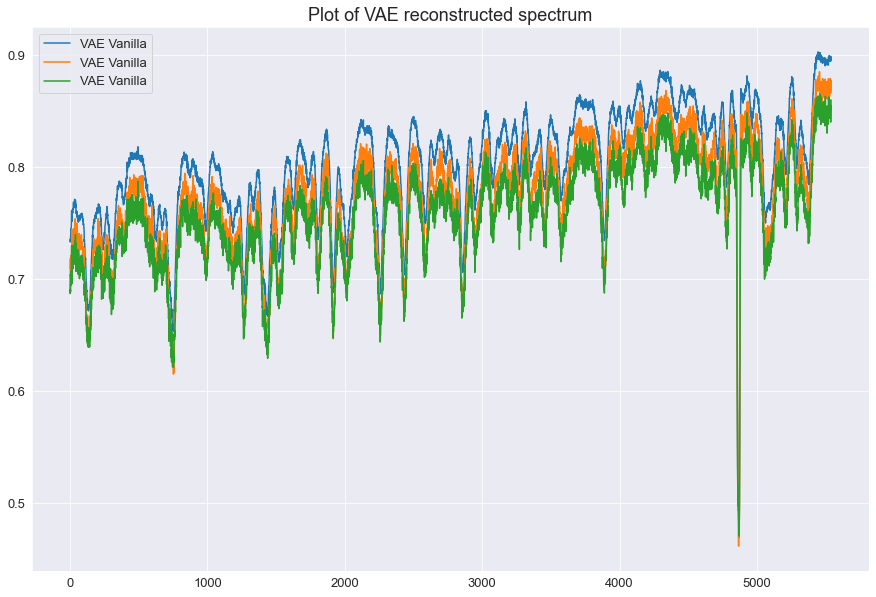

In [29]:
plt.figure(figsize=(15,10))
plt.plot(x_recon[0][0],label='VAE Vanilla')
plt.plot(x_recon[200][0],label='VAE Vanilla')
plt.plot(x_recon[500][0],label='VAE Vanilla')


plt.legend()
plt.title('Plot of VAE reconstructed spectrum')
plt.show()

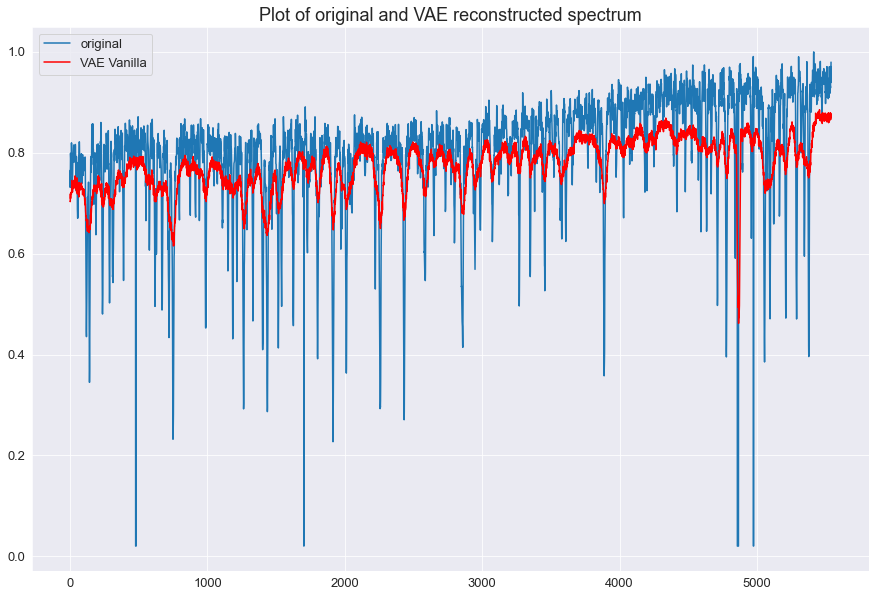

In [30]:
plt.figure(figsize=(15,10))
plt.plot(learning_spectra[200][0],label='original')
plt.plot(x_recon[200][0],label='VAE Vanilla',color='red')
#plt.ylim(0.005,0.020)
plt.title('Plot of original and VAE reconstructed spectrum')
plt.legend()
plt.show()

# 3.5 Analysis of Latent Parameters

In [31]:
x_mean=x_recon

In [32]:
z=z.reshape([z.shape[0],z.shape[1]])

ValueError: cannot reshape array of size 41730 into shape (20865,1)

In [ ]:
z

array([[ 0.08907807, 11.249246  ],
       [ 0.5351601 , 12.668684  ],
       [-0.3924629 ,  9.240371  ],
       ...,
       [ 0.5672588 , 12.474799  ],
       [-0.12880036, 10.32419   ],
       [ 0.40444934, 11.925554  ]], dtype=float32)

In [ ]:
pca_coeff=pd.DataFrame(data=z)
analysis=HR10.loc[:, HR10.columns != 'spectrum']

In [ ]:
param=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD']#, 'XI']

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

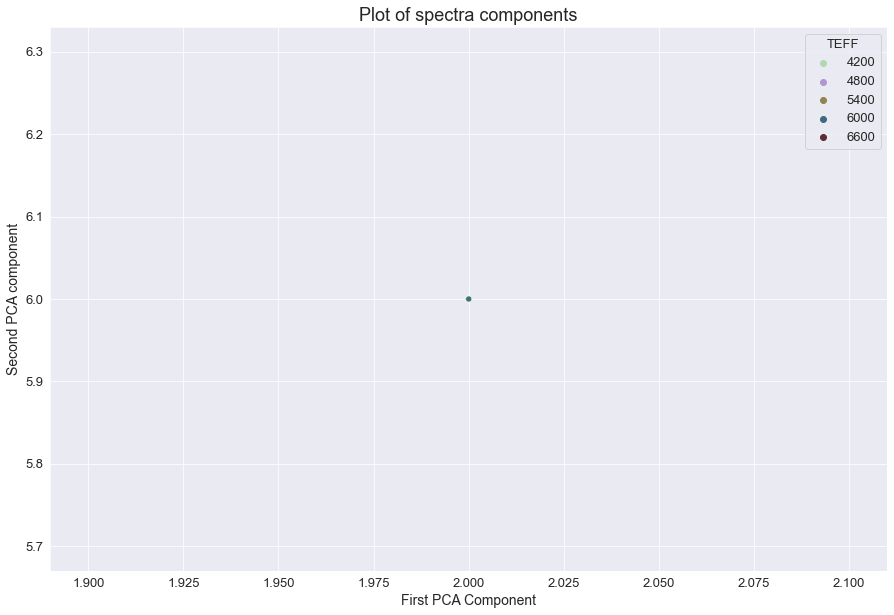

In [ ]:
i=1
pca_analysis=pd.concat([analysis[param],pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis[param[i]]!='nan']

pca_analysis[param[i]]=pca_analysis[param[i]].astype(float)

plt.figure(figsize=(15,10))
sn.scatterplot(data=pca_analysis,x=2,y=6, hue=param[i], palette="ch:r=-3,l=0.9")

plt.title('Plot of spectra components')
plt.ylabel('Second PCA component')
plt.xlabel('First PCA Component')

sn.heatmap

In [ ]:
corr=pca_analysis.corr().loc[param]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_9085/3384151885.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,DIST_GAIA,TEFF,LOGG,FEH,VRAD,0,1
DIST_GAIA,1.00,-0.04,0.07,-0.03,-0.06,-0.06,-0.07
TEFF,-0.04,1.00,0.47,0.01,0.06,0.68,0.63
LOGG,0.07,0.47,1.00,0.38,-0.08,0.11,0.09
FEH,-0.03,0.01,0.38,1.00,-0.16,-0.35,-0.35
VRAD,-0.06,0.06,-0.08,-0.16,1.00,0.13,0.11
